# Optimizing Plan Utility: Using SymK in the Unified Planning Library

In [1]:
import networkx as nx
import matplotlib
import random
import sys
import time
import up_symk
import unified_planning as up

from collections import defaultdict
from unified_planning.shortcuts import *

seed = 1
random.seed(seed)

## Validator
We define two functions that serve as helper functions to evaluate the found plans and calculate the cost of the plans.

In [2]:
def get_plan_qualities(problem, plan):
    qualities = []
    for qm in problem.quality_metrics:
        new_problem = problem.clone()
        new_problem.clear_quality_metrics()
        new_problem.add_quality_metric(qm)
        pv = PlanValidator(problem_kind=new_problem.kind)
        pv_res = pv.validate(new_problem, plan)
        qualities.append(pv_res.metric_evaluations[qm])
    return qualities

def get_plans_min_max_qualities(problem, plans):
    qualities = []
    for qm in problem.quality_metrics:
        min_q = float('inf')
        max_q = -float('inf')
        new_problem = problem.clone()
        new_problem.clear_quality_metrics()
        new_problem.add_quality_metric(qm)
        pv = PlanValidator(problem_kind=new_problem.kind)
        for plan in plans:
            pv_res = pv.validate(new_problem, plan)
            cur_q = pv_res.metric_evaluations[qm]
            min_q = min(min_q, cur_q)
            max_q = max(max_q, cur_q)
        qualities.append((min_q, max_q))
    return qualities    

## A simple example planning task
To illustrate, we randomly generate a planning task where a single truck with no capacity limit has to deliver a number of parcels of different importance between locations on a graph. Note that the road network is modeled as a directed graph, and it is possible that not all parcels can be delivered.

Jobs:
Parcel 0 from location 1 to location 5 with imporantce 1
Parcel 1 from location 2 to location 0 with imporantce 7
Parcel 2 from location 3 to location 4 with imporantce 6
Parcel 3 from location 1 to location 0 with imporantce 7
Parcel 4 from location 0 to location 4 with imporantce 6
Parcel 5 from location 4 to location 0 with imporantce 7
Parcel 6 from location 2 to location 1 with imporantce 9
Parcel 7 from location 0 to location 3 with imporantce 0
Parcel 8 from location 0 to location 1 with imporantce 8
Parcel 9 from location 0 to location 4 with imporantce 3
Parcel 10 from location 3 to location 0 with imporantce 8
Parcel 11 from location 1 to location 4 with imporantce 7
The truck is at location 4


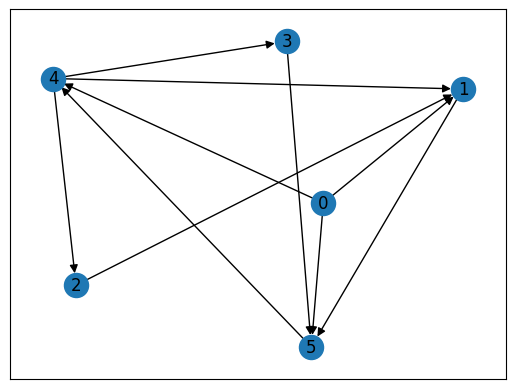

In [3]:
def generate_problem(num_locations, num_parcels):
    # generate a random connected graph with the locations 
    graph = nx.fast_gnp_random_graph(num_locations, 0.31, directed=True, seed=seed)

    # randomly choose the origin and destination of every parcel
    jobs = []
    for parcel in range(num_parcels):
        origin = random.randrange(num_locations) 
        destination = random.choice([x for x in range(num_locations)
                                     if x != origin])
        importance = random.randrange(10)
        jobs.append((origin, destination, importance))


    # randlomly choose a truck location
    truck_location = random.randrange(num_locations)
    return graph, jobs, truck_location

num_locations = 6
num_parcels = 12
graph, jobs, truck_location = generate_problem(num_locations, num_parcels)

nx.draw_networkx(graph, with_labels=True, arrows=True, arrowsize=12) # uncomment if you do not have matplotlib
print("Jobs:")
for parcel_id, (origin, destination, importance) in enumerate(jobs):
    print('Parcel', parcel_id, 'from location', origin,
          'to location', destination, "with imporantce", importance) 
print('The truck is at location', truck_location)

The possible actions in the planning task are to move the truck from a location to a connected location, to load a parcel (if the truck is at the same location), and to unload the parcel at the destination location.

We use a unary predicate ``truck_at`` and a binary predicate ``parcel_at`` to represent the locations of the truck and all the parcels. The unary predicates ``parcel_loaded`` and ``delivered`` express that a parcel is in the truck or has been delivered. The destinations of the parcels are represented by the binary predicate ``destination`` and the connections (edges) by the binary predicate ``connected``. 

The goal is oversubscribed in the sense that for each parcel we successfully deliver, we get the importance value of the parcel.

In [4]:
def get_planning_task(graph, jobs, truck_location):
    num_parcels = len(jobs)
    num_locations = len(graph)
    # declare user types
    Location = UserType('Location')
    Parcel = UserType('Parcel')

    # declare predicates
    truck_at = up.model.Fluent('truck_at', BoolType(), l=Location)
    parcel_at = up.model.Fluent('parcel_at', BoolType(), p=Parcel, l=Location)
    parcel_loaded = up.model.Fluent('parcel_loaded', BoolType(), p=Parcel)
    delivered = up.model.Fluent('delivered', BoolType(), p=Parcel)
    destination = up.model.Fluent('destination', BoolType(), p=Parcel, l=Location)
    connected = up.model.Fluent('connected', BoolType(), l_from=Location, l_to=Location)

    # add (typed) objects to problem
    problem = up.model.Problem('parcels')
    locations = [up.model.Object('loc%s' % i, Location)
                 for i in range(num_locations)]
    parcels = [up.model.Object('parcel%s' % i, Parcel)
               for i in range(num_parcels)]
    problem.add_objects(locations)
    problem.add_objects(parcels)

    # specify the initial state
    problem.add_fluent(truck_at, default_initial_value=False)
    problem.add_fluent(parcel_at, default_initial_value=False)
    problem.add_fluent(parcel_loaded, default_initial_value=False)
    problem.add_fluent(delivered, default_initial_value=False)
    problem.add_fluent(destination, default_initial_value=False)
    problem.add_fluent(connected, default_initial_value=False)
    for parcel_id, (origin, dest, _) in enumerate(jobs):
        p = parcels[parcel_id]
        problem.set_initial_value(parcel_at(p, locations[origin]), True)
        problem.set_initial_value(destination(p, locations[dest]), True)
    for (l1, l2) in graph.edges():
        problem.set_initial_value(connected(locations[l1], locations[l2]), True)
        # problem.set_initial_value(connected(locations[l2], locations[l1]), True)
    problem.set_initial_value(truck_at(locations[truck_location]), True)

    # add actions
    move = up.model.InstantaneousAction('move', l_from=Location, l_to=Location)
    l_from = move.parameter('l_from')
    l_to = move.parameter('l_to')
    move.add_precondition(connected(l_from, l_to))
    move.add_precondition(truck_at(l_from))
    move.add_effect(truck_at(l_from), False)
    move.add_effect(truck_at(l_to), True)
    problem.add_action(move)

    load = up.model.InstantaneousAction('load', p=Parcel, l=Location)
    p = load.parameter('p')
    loc = load.parameter('l')
    load.add_precondition(truck_at(loc))
    load.add_precondition(parcel_at(p, loc))
    load.add_effect(parcel_at(p, loc), False)
    load.add_effect(parcel_loaded(p), True)
    problem.add_action(load)

    unload = up.model.InstantaneousAction('unload', p=Parcel, l=Location)
    p = unload.parameter('p')
    loc = unload.parameter('l')
    unload.add_precondition(truck_at(loc))
    unload.add_precondition(parcel_loaded(p))
    unload.add_precondition(destination(p, loc))
    unload.add_effect(delivered(p), True)
    unload.add_effect(parcel_loaded(p), False)
    problem.add_action(unload)
    
    # specify the goal: all parcels should have been delivered
    goals = {}
    for parcel_id, (_, _, importance) in enumerate(jobs):
        p = parcels[parcel_id]
        goals[delivered(p)] = importance
        
    problem.add_quality_metric(up.model.metrics.Oversubscription(goals))
    
    return problem

problem = get_planning_task(graph, jobs, truck_location)
print("Goals with utilities:")
for g, u in problem.quality_metrics[0].goals.items():
    print(g, u)

Goals with utilities:
delivered(parcel0) 1
delivered(parcel1) 7
delivered(parcel2) 6
delivered(parcel3) 7
delivered(parcel4) 6
delivered(parcel5) 7
delivered(parcel6) 9
delivered(parcel7) 0
delivered(parcel8) 8
delivered(parcel9) 3
delivered(parcel10) 8
delivered(parcel11) 7


## Finding a single optimal solution
We solve our problem optimally with ``symk-opt``, i.e., we find a plan with the highest possible utility.

In [5]:
with OneshotPlanner(name="symk-opt") as planner:
    start_time = time.time()
    result = planner.solve(problem)
    execution_time = time.time() - start_time 
    plan = result.plan
    assert plan is not None
    qualities = get_plan_qualities(problem, plan)
    assert len(qualities) == 1
    utility = qualities[0]
    print(f"{planner.name} returned: {result.plan} with a utility of {utility} in {execution_time:.6f} seconds.")
    
# We do not want to see the credits again and again, so let's disable them from now on.
up.shortcuts.get_environment().credits_stream = None

NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_107434/1197866876.py`, you are using the following planning engine:
  * Engine name: SymK
  * Developers:  David Speck (cf. https://github.com/speckdavid/symk/blob/master/README.md )
  * Description: SymK is a state-of-the-art domain-independent optimal and top-k planner.

SymK (with optimality guarantee) returned: SequentialPlan:
    move(loc4, loc3)
    load(parcel2, loc3)
    move(loc3, loc5)
    move(loc5, loc4)
    unload(parcel2, loc4)
    move(loc4, loc2)
    load(parcel6, loc2)
    move(loc2, loc1)
    unload(parcel6, loc1)
    load(parcel11, loc1)
    load(parcel0, loc1)
    move(loc1, loc5)
    unload(parcel0, loc5)
    move(loc5, loc4)
    unload(parcel11, loc4) with a utility of 23 in 0.273121 seconds.


We can also use the ``oversubscription`` meta-engine (here with ``tamer``). However, this has some disadvantages compared to using ``symk-opt`` or ``symk``, which supports oversubscription tasks natively. The meta-engine employs a compilation technique, generating a planning task for the powerset of all goals, which can result in significant exponential overhead, as evident to some extent in this example. Furthermore, planning engines based on Fast Downward may not be able to handle the negated goal facts introduced by the compilation. We recommend the use of ``symk-opt`` or ``symk``.

In [6]:
!pip install up_tamer

with OneshotPlanner(name="oversubscription[tamer]") as planner:
    start_time = time.time()
    result = planner.solve(problem)
    execution_time = time.time() - start_time 
    plan = result.plan
    assert plan is not None
    qualities = get_plan_qualities(problem, plan)
    assert len(qualities) == 1
    utility = qualities[0]
    print(f"{planner.name} returned: {result.plan} with a utility of {utility} in {execution_time:.6f} seconds.")

Defaulting to user installation because normal site-packages is not writeable
OversubscriptionPlanner[Tamer] returned: SequentialPlan:
    move(loc4, loc1)
    load(parcel0, loc1)
    load(parcel11, loc1)
    move(loc1, loc5)
    unload(parcel0, loc5)
    move(loc5, loc4)
    unload(parcel11, loc4)
    move(loc4, loc2)
    load(parcel6, loc2)
    move(loc2, loc1)
    unload(parcel6, loc1)
    move(loc1, loc5)
    move(loc5, loc4)
    move(loc4, loc3)
    load(parcel2, loc3)
    move(loc3, loc5)
    move(loc5, loc4)
    unload(parcel2, loc4) with a utility of 23 in 46.055112 seconds.


## Finding a single optimal solution for a given cost bound
With ``symk-opt`` it is possible to find the best solution, i.e., the solution that maximizes the utility of the end state with respect to a given cost bound (here: plan length) that can be specified as an additional parameter. Here we ask for a solution that maximizes utility and has a cost lower than 7.

In [7]:
if MinimizeSequentialPlanLength() not in problem.quality_metrics:
    problem.add_quality_metric(MinimizeSequentialPlanLength())

with OneshotPlanner(name="symk-opt", params={"plan_cost_bound": 7}) as planner:
    start_time = time.time()
    result = planner.solve(problem)
    execution_time = time.time() - start_time 
    plan = result.plan
    assert plan is not None
    qualities = get_plan_qualities(problem, plan)
    assert len(qualities) == 2
    utility, plan_length = qualities
    print(f"{planner.name} returned: {result.plan} with a utility of {utility} and plan length of {plan_length} in {execution_time:.6f} seconds.")

SymK (with optimality guarantee) returned: SequentialPlan:
    move(loc4, loc2)
    load(parcel6, loc2)
    move(loc2, loc1)
    unload(parcel6, loc1) with a utility of 9 and plan length of 4 in 0.245797 seconds.


## Finding multiple optimal solutions
We solve the problem with ``symk-opt`` and ask for all optimal solutions, i.e., all solutions that maximize utility at potentially different costs (here: plan length).

In [8]:
plans = []

with AnytimePlanner(name='symk-opt') as planner:
    for i, result in enumerate(planner.get_solutions(problem)):
        if result.status == up.engines.PlanGenerationResultStatus.INTERMEDIATE:
            plans.append(result.plan)
            if i > 0 and i % 100 == 0:
                print(f"{planner.name} found {i} plans...")
        elif result.status in unified_planning.engines.results.POSITIVE_OUTCOMES:
            print()
            print(f"{planner.name} found {i} plans!")
            print()
        elif result.status not in unified_planning.engines.results.POSITIVE_OUTCOMES:
            print("No plan found.")
            
# Calculate the utlities and costs of the plans found
print("Calculate the utlities and costs of the plans found...")

utils, costs = get_plans_min_max_qualities(problem, plans)
assert utils[0] == utils[1]
    
print(f"{planner.name} found {len(plans)} plans with utility {utils[0]} and costs between {costs[0]} and {costs[1]}.")

SymK (with optimality guarantee) found 100 plans...
SymK (with optimality guarantee) found 200 plans...
SymK (with optimality guarantee) found 300 plans...
SymK (with optimality guarantee) found 400 plans...
SymK (with optimality guarantee) found 500 plans...
SymK (with optimality guarantee) found 600 plans...
SymK (with optimality guarantee) found 700 plans...
SymK (with optimality guarantee) found 800 plans...

SymK (with optimality guarantee) found 858 plans!

Calculate the utlities and costs of the plans found...
SymK (with optimality guarantee) found 858 plans with utility 23 and costs between 15 and 18.


## Find multiple solutions ordered by utility
Again we solve our problem, this time asking for 250 plans with cost less than 10. Our ``symk`` engine produces the solutions ordered by utility and then by cost (here: plan length), starting with the best ones, so that we find solutions that vary in utility and cost.

In [ ]:
plans = []

with AnytimePlanner(name='symk', params={"plan_cost_bound": 10, "number_of_plans": 250}) as planner:
    for i, result in enumerate(planner.get_solutions(problem)):
        if result.status == up.engines.PlanGenerationResultStatus.INTERMEDIATE:
            plans.append(result.plan)
            if i > 0 and i % 100 == 0:
                print(f"{planner.name} found {i} plans...")
        elif result.status in unified_planning.engines.results.POSITIVE_OUTCOMES:
            print()
            print(f"{planner.name} found {i} plans!")
            print()
        elif result.status not in unified_planning.engines.results.POSITIVE_OUTCOMES:
            print("No plan found.")
            
# Calculate the utlities and costs of the plans found
print("Calculate the utlities and costs of the plans found...")

utils, costs = get_plans_min_max_qualities(problem, plans)
    
print(f"{planner.name} found {len(plans)} plans with utilities between {utils[1]} and {utils[0]} and costs between {costs[0]} and {costs[1]}.")

SymK found 100 plans...
SymK found 200 plans...

SymK found 250 plans!

Calculate the utlities and costs of the plans found...
